In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder
FOLDERNAME = 'cs231n/final_project/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler, Subset
import torch.nn.functional as F

import torchvision.datasets as dset
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd


import numpy as np

USE_GPU = True
dtype = torch.float32 # We will be using float throughout this tutorial.

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss.
# print_every = 300
batch_size = 64
len_data = 12000
data_dir = '/content/drive/My Drive/cs231n/final_project/all_fish_pics/'
print('using device:', device)

using device: cuda


In [3]:
classes = os.listdir(data_dir)

In [4]:
train_tfms = T.Compose([
    T.ToTensor()
])

all_data = ImageFolder(data_dir, transform=train_tfms)
# print(all_data.class_to_idx)
all_data = Subset(all_data, np.random.choice(len(all_data), len_data, replace=False))
print(all_data[0][0].shape)
print(len(all_data))

train_len = int(len_data*0.7)
val_len = int(len_data*0.2)
test_len = len_data - (train_len + val_len)
train, val, test = torch.utils.data.random_split(all_data, [train_len, val_len, test_len])
train_dl = DataLoader(train, batch_size, shuffle=True, pin_memory=True)
val_dl = DataLoader(val, batch_size, shuffle=True, pin_memory=True)
test_dl = DataLoader(test, batch_size, shuffle=True, pin_memory=True)

torch.Size([3, 256, 256])
12000


In [5]:
def flatten(x):
    N = x.shape[0] 
    return x.view(N, -1)

In [6]:
def check_accuracy(loader, model, threshold = 3):
    num_correct = 0
    num_samples = 0

    num_correct3 = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            # check accuracy with predicted result
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            
            # check acc@3
            _, pred = scores.topk(threshold, 1, True, True)
            pred = pred.t()
            correct = pred.eq(y.view(1, -1).expand_as(pred))

            correct_k = correct[:threshold].reshape(-1).float().sum(0)
            num_correct3 += correct_k

        acc = float(num_correct) / num_samples
        acc3 = float(num_correct3) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        print(f'Got acc@{threshold}: {acc3 * 100}\%')
        return 100*acc, 100*acc3

In [7]:
def train(model, optimizer, epochs=1, name='generic_run'):
    """
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for    
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    accs = []
    accs_top3 = []
    best_acc = -1
    for e in range(epochs):
        print(f'Epoch {e+1}')
        for t, (x, y) in enumerate(train_dl):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        acc, accs3 = check_accuracy(val_dl, model)
        if acc > best_acc: 
          print('Saving model...')
          torch.save(model.state_dict(), f'/content/drive/My Drive/{FOLDERNAME}results/{name}.pth')
          best_acc = acc
        accs.append(acc)
        accs_top3.append(accs3)
    data = pd.DataFrame({'epoch': list(range(e+1)), 'acc': accs, 'acc_3': accs_top3})
    data.to_csv(f'/content/drive/My Drive/{FOLDERNAME}results/{name}.csv')

    return accs, accs_top3

In [8]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ELU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet(nn.Module):
  def __init__(self, in_channel, out_channel):
    super().__init__()

    # Define the layers

    self.conv1 = conv_block(in_channels, 128)
    self.conv2 = conv_block(128, 128, pool=True)
    self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
    self.drop1 = nn.Dropout(0.5)

    self.conv3 = conv_block(128, 256)
    self.conv4 = conv_block(256, 256, pool=True)
    self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
    self.drop2 = nn.Dropout(0.5)

    self.conv5 = conv_block(256, 512)
    self.conv6 = conv_block(512, 512, pool=True)
    self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
    self.drop3 = nn.Dropout(0.5)

    self.classifier = nn.Sequential(nn.Flatten(),nn.Linear(8*256*256, out_channel))

  def forward(self,x):
    out = self.conv1(x)
    out = self.conv2(out)
    out = self.res1(out) + out
    out = self.drop1(out)

    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out
    out = self.drop2(out)
        
    out = self.conv5(out)
    out = self.conv6(out)
    out = self.res3(out) + out
    out = self.drop3(out)

    scores = self.classifier(out)
    return scores


In [9]:
def plot_accuracies(learning_rates,accuracies, labels):
    for i,acc in enumerate(accuracies):
        plt.plot(learning_rates, acc, label = labels[i])
    plt.legend()
    plt.xlabel("learning rate")
    plt.ylabel("final validation accuracy")
    plt.title("Validation accuracy vs learning rate")

In [10]:
class ThreeLayerFC(nn.Module):
  def __init__(self, in_channel, channel_1, channel_2, num_classes):
    super().__init__()

    # Define the layers
    # self.conv_1 = nn.Conv2d(in_channel,channel_1,(5,5),padding=2)
    # nn.init.kaiming_normal_(self.conv_1.weight)
    # self.conv_2 = nn.Conv2d(channel_1,channel_2,(3,3),padding=1)
    # nn.init.kaiming_normal_(self.conv_2.weight)

    self.fc1 = nn.Linear(in_channel*256*256,channel_1)
    nn.init.kaiming_normal_(self.fc1.weight)

    self.fc2 = nn.Linear(channel_1,channel_2)
    nn.init.kaiming_normal_(self.fc2.weight)

    self.fc3 = nn.Linear(channel_2,num_classes)
    nn.init.kaiming_normal_(self.fc3.weight)

  def forward(self,x):
    x = flatten(x)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    scores = self.fc3(x)
    return scores


Epoch 1
Got 332 / 2400 correct (13.83)
Got acc@3: 25.5\%
Saving model...
Epoch 2
Got 405 / 2400 correct (16.88)
Got acc@3: 31.624999999999996\%
Saving model...
Epoch 3
Got 479 / 2400 correct (19.96)
Got acc@3: 33.416666666666664\%
Saving model...
Epoch 4
Got 537 / 2400 correct (22.38)
Got acc@3: 34.166666666666664\%
Saving model...
Epoch 5
Got 547 / 2400 correct (22.79)
Got acc@3: 35.75\%
Saving model...
Epoch 6
Got 576 / 2400 correct (24.00)
Got acc@3: 37.708333333333336\%
Saving model...
Epoch 7
Got 505 / 2400 correct (21.04)
Got acc@3: 34.208333333333336\%
Epoch 8
Got 567 / 2400 correct (23.62)
Got acc@3: 37.666666666666664\%
Epoch 9
Got 613 / 2400 correct (25.54)
Got acc@3: 40.375\%
Saving model...
Epoch 10
Got 630 / 2400 correct (26.25)
Got acc@3: 40.208333333333336\%
Saving model...
Epoch 11
Got 589 / 2400 correct (24.54)
Got acc@3: 39.04166666666667\%
Epoch 12
Got 589 / 2400 correct (24.54)
Got acc@3: 38.166666666666664\%
Epoch 13
Got 661 / 2400 correct (27.54)
Got acc@3: 41.625

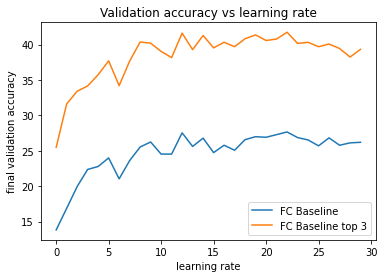

In [11]:
lr = 1e-4
in_channels = 3
num_epochs = 30

model = ThreeLayerFC(in_channels, 1000, 500, len(classes))
optimizer = optim.Adam(model.parameters(), lr = lr)

accs,accs_top3 = train(model, optimizer, epochs=num_epochs, name='fc_baseline_all')


print(accs)
print(accs_top3)
labels = ['FC Baseline','FC Baseline top 3']
epochs = np.arange(num_epochs)
plot_accuracies(epochs,[accs,accs_top3],labels)

In [ ]:
lr = 1e-4
in_channels = 3
num_epochs = 30

model = ResNet(in_channels, len(classes))
optimizer = optim.Adam(model.parameters(), lr = lr)

accs,accs_top3 = train(model, optimizer, epochs=num_epochs, name='resnet_baseline_top_20')


print(accs)
print(accs_top3)
labels = ['ResNet Baseline','ResNet Baseline top 3']
epochs = np.arange(num_epochs)
plot_accuracies(epochs,[accs,accs_top3],labels)

Epoch 1


RuntimeError: ignored

In [ ]:
def load_model(model, path): 
  '''
  Load model from saved parameters.
  '''
  model.load_state_dict(torch.load(path))
  model.to(device)
  model.eval()
  return model

# test_model = ResNet(in_channels,len(classes))
# test_model.load_state_dict(torch.load(f'/content/drive/My Drive/{FOLDERNAME}results/test_run_small_data.pth'))
# test_model.to(device)
# os.listdir(f'/content/drive/My Drive/{FOLDERNAME}results')
# test_model.eval()
# test_model = load_model(test_model, f'/content/drive/My Drive/{FOLDERNAME}results/test_run_small_data.pth')

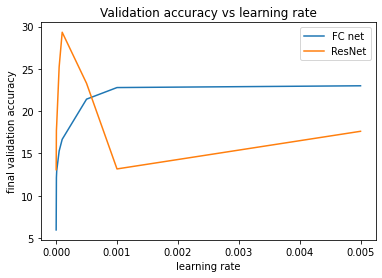

In [ ]:
lrs = [1e-6,5e-6,1e-5,5e-5,1e-4,5e-4,1e-3,5e-3]
accs_1 = [5.96,12.125,12.96,15.29,16.67,21.42,22.79,23.0]
accs_2 = [13.08,17.71,18.46,25.23,29.33,23.29,13.17,17.62]
accs = [accs_1,accs_2]
labels = ['FC net','ResNet']
plot_accuracies(lrs,accs,labels)

Epoch 1
Got 396 / 2400 correct (16.50)
Epoch 2
Got 463 / 2400 correct (19.29)
Epoch 3
Got 502 / 2400 correct (20.92)
Epoch 4
Got 528 / 2400 correct (22.00)
Epoch 5
Got 547 / 2400 correct (22.79)
Epoch 1
Got 403 / 2400 correct (16.79)
Epoch 2
Got 502 / 2400 correct (20.92)
Epoch 3
Got 533 / 2400 correct (22.21)
Epoch 4
Got 536 / 2400 correct (22.33)
Epoch 5
Got 552 / 2400 correct (23.00)
Epoch 1
Got 308 / 2400 correct (12.83)
Epoch 2
Got 340 / 2400 correct (14.17)
Epoch 3
Got 367 / 2400 correct (15.29)
Epoch 4
Got 380 / 2400 correct (15.83)
Epoch 5
Got 400 / 2400 correct (16.67)
Epoch 1
Got 376 / 2400 correct (15.67)
Epoch 2
Got 430 / 2400 correct (17.92)
Epoch 3
Got 442 / 2400 correct (18.42)
Epoch 4
Got 473 / 2400 correct (19.71)
Epoch 5
Got 514 / 2400 correct (21.42)
Epoch 1
Got 228 / 2400 correct (9.50)
Epoch 2
Got 226 / 2400 correct (9.42)
Epoch 3
Got 241 / 2400 correct (10.04)
Epoch 4
Got 288 / 2400 correct (12.00)
Epoch 5
Got 311 / 2400 correct (12.96)
Epoch 1
Got 312 / 2400 corr

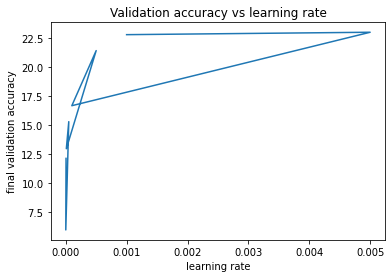

In [ ]:
learning_rates = [1e-3,5e-3,1e-4,5e-4,1e-5,5e-5,1e-6,5e-6]
channel_1 = 1000
channel_2 = 500

models_accs = []
for lr in learning_rates:
  model = ThreeLayerFC(3,channel_1,channel_2,len(classes))
  optimizer = optim.SGD(model.parameters(), lr = lr)

  acc = train(model, optimizer, epochs=5)
  models_accs.append(acc)

print(models_accs)
plot_accuracies(learning_rates,models_accs)

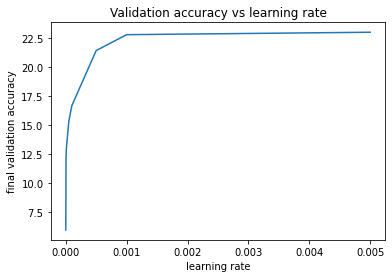

In [ ]:
lrs = [1e-6,5e-6,1e-5,5e-5,1e-4,5e-4,1e-3,5e-3]
accs = [5.96,12.125,12.96,15.29,16.67,21.42,22.79,23.0]
plot_accuracies(lrs,accs)

Epoch 1
Got 413 / 2400 correct (17.21)
Epoch 2
Got 508 / 2400 correct (21.17)
Epoch 3
Got 578 / 2400 correct (24.08)
Epoch 4
Got 638 / 2400 correct (26.58)
Epoch 5
Got 619 / 2400 correct (25.79)
Epoch 6
Got 721 / 2400 correct (30.04)
Epoch 7
Got 750 / 2400 correct (31.25)
Epoch 8
Got 746 / 2400 correct (31.08)
Epoch 9
Got 774 / 2400 correct (32.25)
Epoch 10
Got 801 / 2400 correct (33.38)
Epoch 11
Got 742 / 2400 correct (30.92)
Epoch 12
Got 742 / 2400 correct (30.92)
Epoch 13
Got 799 / 2400 correct (33.29)
Epoch 14
Got 813 / 2400 correct (33.88)
Epoch 15
Got 808 / 2400 correct (33.67)
Epoch 16
Got 791 / 2400 correct (32.96)
Epoch 17
Got 811 / 2400 correct (33.79)
Epoch 18
Got 809 / 2400 correct (33.71)
Epoch 19
Got 816 / 2400 correct (34.00)
Epoch 20
Got 812 / 2400 correct (33.83)
[17.208333333333332, 21.166666666666668, 24.083333333333336, 26.583333333333332, 25.791666666666668, 30.041666666666668, 31.25, 31.083333333333336, 32.25, 33.375, 30.916666666666664, 30.916666666666664, 33.291

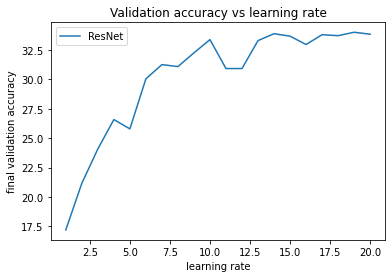

In [ ]:
learning_rates = [1e-4]
in_channels = 3

accs = []
for lr in learning_rates:
  model = ResNet(in_channels,len(classes))
  optimizer = optim.SGD(model.parameters(), lr = lr)

  accs = train(model,optimizer,epochs=20)


print(accs)
labels = ['ResNet']
epochs = np.arange(1,21)
plot_accuracies(epochs,[accs],labels)

TODO:

Make new dataset folder

Create new models

1. VGG Net
2. AlexNet
3. Improved ResNet

Plot accuracies over 30 epochs for each

In [ ]:
# skeleton code for training loop of multiple models
vgg = VGGNet(..., ..., name='VGGNet')
alexnet = AlexNet(..., ..., name=...)
resnet = ResNet(..., ..., name=...)

lr = 1e-4
num_epochs = 15
in_channels = 3

for model in (vgg, alexnet, resnet): 
  name = 'name_of_model'
  optimizer = optim.Adam(model.parameters(), lr = lr)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

  accs, accs_top3 = train(model, optimizer, scheduler, epochs=num_epochs, name='test_run_small_data')


print(accs)
print(accs_top3)
labels = ['ResNet','ResNet top 3']
epochs = np.arange(num_epochs)
plot_accuracies(epochs,[accs,accs_top3],labels)